In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

# Import and Preprocess 

In [8]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leonardramsey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Revised import function

We pause to look at the revised form of our text import function. The parsing function has been replaced with NLTK, which has improved the results of POS tagging. However, this has required some added string manipulation to produce better tokens.

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
"""
NOTE: NLTK tokenization messes up whitespace and 
handles non-alpha characters differently.
"""

def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [17]:
src_file_name = '2701-0.txt'
src_file_url = 'https://www.gutenberg.org/files/2701/2701-0.txt'

import os

K_list = []
V_list = []

src_file_names = [
                 '2701-0.txt',
#                  'corpus/a_tale_of_two_cities.txt',
#                  'corpus/anna_karenina.txt',
                 'corpus/captains_courageous.txt',
#                  'corpus/emma.txt',
                 'corpus/far_from_madding_crowd.txt',
#                  'corpus/heart_of_darkness.txt',
                 'corpus/jane_eyre.txt',
#                  'corpus/pride_and_prejudice.txt'
                 ]
body_starts = [
               341, # 2701-0
#                111, # a tale of 2 cities
#                341, # anna karenina
               38, # captains courageous
#                341, # emma
               112, # far from madding crowd
#                341, # heart of darkness
               72 # jane eyre
#                341 # pride and predjudice
               ]
body_ends = [
            21964, # 2701-0
#             15900, # a tale of 2 cities
#             21964, # anna karenina
            6185, # captains courageous
#             21964, # emma
            17196, # far from madding crowd
#             21964, # heart of darkness
            20700 # jane eyre
#             13339, # pride and predjudice
            ]
chap_pats = [
            r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # 2701-0
#             r'^\s*(...).*$', # a tale of 2 cities
#             r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # anna karenina
            r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # captains courageous
#             r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # emma
            r'^\s*(?:CHAPTER|PREFACE).*$', # far from madding crowd
#             r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # heart of darkness
            r'^\s*(?:CHAPTER|PREFACE|Epilogue).*$' # jane eyre
#             r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$' # pride and predjudice
            ]

for s in range(0,len(src_file_names)):
    print('iteration %d' % s)
    print('src_file_name %s' % src_file_names[s])
    print('body_start %d' % body_starts[s])
    print('body_end %d' % body_ends[s])
    print('chap_pat %s' % chap_pats[s])
    cfg = dict(
        src_file = src_file_names[s],
        body_start = body_starts[s],
        body_end = body_ends[s],
        chap_pat = chap_pats[s]
    )
    print(cfg)
#     cfg2 = dict(
#         src_file = '2701-0.txt',
#         body_start = 341,
#         body_end = 21964,
#         chap_pat = r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'
#     )
#     print(cfg2)

    K, V = text_to_tokens(**cfg)
    K_list.append(K)
    V_list.append(V)
    K_list[s].head()
    V_list[s].head()

iteration 0
src_file_name 2701-0.txt
body_start 341
body_end 21964
chap_pat ^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$
{'src_file': '2701-0.txt', 'body_start': 341, 'body_end': 21964, 'chap_pat': '^\\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'}
iteration 1
src_file_name corpus/captains_courageous.txt
body_start 38
body_end 6185
chap_pat ^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$
{'src_file': 'corpus/captains_courageous.txt', 'body_start': 38, 'body_end': 6185, 'chap_pat': '^\\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'}
iteration 2
src_file_name corpus/far_from_madding_crowd.txt
body_start 112
body_end 17196
chap_pat ^\s*(?:CHAPTER|PREFACE).*$
{'src_file': 'corpus/far_from_madding_crowd.txt', 'body_start': 112, 'body_end': 17196, 'chap_pat': '^\\s*(?:CHAPTER|PREFACE).*$'}
iteration 3
src_file_name corpus/jane_eyre.txt
body_start 72
body_end 20700
chap_pat ^\s*(?:CHAPTER|PREFACE|Epilogue).*$
{'src_file': 'corpus/jane_eyre.txt', 'body_start': 72, 'body_end': 20700, 'chap_pat': '^\\s*(?:CHAPTER|PREFACE|Epilogue)

In [18]:
# lemmatizer = nltk.stem.WordNetLemmatizer()
# # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
# nouns = (K.punc == 0) & K.pos.str.match(r'^N')
# verbs = (K.punc == 0) & K.pos.str.match(r'^V')
# K.loc[nouns, 'lemma'] = K[nouns].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='n'), 1)
# K.loc[verbs, 'lemma'] = K[verbs].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='v'), 1)

In [19]:
K_list[0].head()

pos  token_str  punc  num   term_str  \
chap_num para_num sent_num token_num                                         
0        0        0        0          NNP  ETYMOLOGY     0    0  etymology   
                           1            .          .     1    0        NaN   
         1        0        0            (          (     1    0        NaN   
                           1          VBN   Supplied     0    0   supplied   
                           2           IN         by     0    0         by   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             5005  
                           1               -1  
         1        0        0               -1  
                           1            14441  
                           2             1987

In [20]:
V_list[0].head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,4724,0.021629,a,1
1,aback,2,0.000009,aback,0
2,abaft,2,0.000009,abaft,0
3,abandon,3,0.000014,abandon,0
4,abandoned,7,0.000032,abandon,0


## Test to see if 'and' is annotated properly

In [21]:
K_list[0][K_list[0].term_str=='and'].pos

chap_num  para_num  sent_num  token_num
0         2         0         12           CC
                    1         7            CC
          3         0         10           CC
          4         1         4            CC
          5         2         0            CC
          8         0         9            CC
                              30           CC
                    3         43           CC
                              51           CC
          9         1         18           CC
                              40           CC
                              48           CC
                              54           CC
                              63           CC
                              67           CC
                    3         8            CC
                    4         5            CC
                              33           CC
                              44           CC
          11        0         1            CC
          15        0         11        

In [22]:
K_list[0][(K_list[0].term_str=='and') & K_list[0].pos.isna()]

,,,,pos,token_str,punc,num,term_str,term_id
chap_num,para_num,sent_num,token_num,,,,,,


## Discussion

* Why does NLTK's parser produce better results? 
* What does this imply about the POS algorithm? 

# Create DTM

*   Which bag? Chapters? Paragraphs?
*   Which item? tokens? terms? stems?
*   Let's try chapters and terms



## Create word mask

Let's filter out stopwords -- another hyperparameter. 

In [23]:
WORDS = (K_list[0].punc == 0) & (K_list[0].num == 0) & K_list[0].term_id.isin(V_list[0][V_list[0].stop==0].index)

## Extrct BOW from tokens

To extract a bag-of-words model from our tokens table, we apply a simple `groupby()` operation. Note that we can drop in our hyperparameters easily -- CHAPS and 'term_id' and be replaced. We can easily write a function to simplify this process and make it more configurable. 


In [24]:
BOW = K_list[0][WORDS].groupby(CHAPS+['term_id'])['term_id'].count() # number of occurrences of word per chapter

In [25]:
BOW.head(10) # narrow/sparse representation, every chapter has only the term ids it contains

chap_num  term_id
0         33         1
          69         1
          70         1
          99         2
          129        1
          138        1
          148        5
          154        1
          157        1
          219        1
Name: term_id, dtype: int64

## Convert BOW to DTM

In [26]:
DTM = BOW.unstack().fillna(0) # every chapter has every term listed, possibility space (wide representation)

In [27]:
DTM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Discussion

* What is added in the process of converting our BOW data frame into a matrix?
* How would you characterize the difference between the BOW and the DTM data frames?



# Compute Term Frequencies and Weights

## Compute TF

In [28]:
alpha = .000001 # We introduce an arbitrary smoothing value, prevents divide-by-0 later on
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [29]:
TF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,...,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017530e-10,5.017535e-04,5.017535e-04
1,9.336958e-10,9.336958e-10,9.336968e-04,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,...,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10,9.336958e-10
2,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,...,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09,1.390796e-09
3,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,...,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10,3.533553e-10
4,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,...,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09,1.264202e-09


In [30]:
TF.sum(1) # check to see each row sums to 1 since probabilities should add up to 1. 
# Note: sum(1) --> add rows (axis 1), not columns (axis 0), defaults to column addition

chap_num
0      1.000002
1      1.000004
2      1.000006
3      1.000001
4      1.000005
5      1.000011
6      1.000009
7      1.000009
8      1.000008
9      1.000002
10     1.000006
11     1.000013
12     1.000010
13     1.000005
14     1.000011
15     1.000007
16     1.000001
17     1.000004
18     1.000006
19     1.000007
20     1.000009
21     1.000008
22     1.000005
23     1.000020
24     1.000005
25     1.000029
26     1.000007
27     1.000005
28     1.000006
29     1.000007
         ...   
107    1.000008
108    1.000005
109    1.000009
110    1.000004
111    1.000016
112    1.000008
113    1.000006
114    1.000012
115    1.000009
116    1.000014
117    1.000016
118    1.000008
119    1.000003
120    1.000037
121    1.000014
122    1.000110
123    1.000007
124    1.000006
125    1.000007
126    1.000006
127    1.000011
128    1.000006
129    1.000013
130    1.000005
131    1.000017
132    1.000005
133    1.000002
134    1.000002
135    1.000002
136    1.000030
Length: 137, dt

## Compute TFIDF

In [31]:
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V[V.stop==0]['df'])

In [32]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,NaN,3.059706e-09,3.059706e-09,2.766199e-09,2.396424e-09,3.561459e-09,3.059706e-09,3.059706e-09,3.561459e-09,3.059706e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.693707e-09,5.693707e-09,5.147535e-03,4.459428e-09,6.627403e-09,5.693707e-09,5.693707e-09,6.627403e-09,5.693707e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,8.481120e-09,8.481120e-09,7.667556e-09,6.642587e-09,9.871916e-09,8.481120e-09,8.481120e-09,9.871916e-09,8.481120e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2.154772e-09,2.154772e-09,1.948072e-09,1.687662e-09,2.508127e-09,2.154772e-09,2.154772e-09,2.508127e-09,2.154772e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,7.709146e-09,7.709146e-09,6.969636e-09,6.037962e-09,8.973349e-09,7.709146e-09,7.709146e-09,8.973349e-09,7.709146e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute TFTH (Experiment)

In [33]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1) # term frequency, term entropy

In [34]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.211250e-11,5.621735e-12,2.023585e-11,3.792247e-11,6.519176e-12,8.523184e-12,1.646779e-11,7.500870e-12,1.361386e-11,2.292865e-12,...,9.155023e-12,3.659841e-11,6.467677e-12,3.043262e-11,3.892699e-12,4.511013e-12,5.806727e-12,6.430017e-12,2.763682e-06,2.763682e-06
1,2.253975e-11,1.046130e-11,3.765628e-05,7.056869e-11,1.213132e-11,1.586052e-11,3.064437e-11,1.395812e-11,2.533359e-11,4.266719e-12,...,1.703628e-11,6.810479e-11,1.203549e-11,5.663108e-11,7.243797e-12,8.394397e-12,1.080555e-11,1.196541e-11,5.142840e-12,5.142840e-12
2,3.357432e-11,1.558274e-11,5.609124e-11,1.051163e-10,1.807034e-11,2.362519e-11,4.564664e-11,2.079147e-11,3.773591e-11,6.355535e-12,...,2.537657e-11,1.014462e-10,1.792759e-11,8.435541e-11,1.079007e-11,1.250396e-11,1.609552e-11,1.782320e-11,7.660570e-12,7.660570e-12
3,8.530124e-12,3.959060e-12,1.425093e-11,2.670658e-11,4.591075e-12,6.002380e-12,1.159730e-11,5.282424e-12,9.587447e-12,1.614731e-12,...,6.447348e-12,2.577412e-11,4.554808e-12,2.143192e-11,2.741401e-12,3.176843e-12,4.089339e-12,4.528285e-12,1.946298e-12,1.946298e-12
4,3.051830e-11,1.416436e-11,5.098567e-11,9.554836e-11,1.642553e-11,2.147477e-11,4.149176e-11,1.889898e-11,3.430109e-11,5.777037e-12,...,2.306673e-11,9.221229e-11,1.629577e-11,7.667716e-11,9.807932e-12,1.136582e-11,1.463046e-11,1.620089e-11,6.963286e-12,6.963286e-12


## Add stats to V

In [35]:
V_list[0]['tf_sum'] = TF.sum()
V_list[0]['tf_mean'] = TF.mean()
V_list[0]['tf_max'] = TF.max()
V_list[0]['tfidf_sum'] = TFIDF.sum()
V_list[0]['tfidf_mean'] = TFIDF.mean()
V_list[0]['tfidf_max'] = TFIDF.max()
V_list[0]['tfth_sum'] = TFTH.sum()
V_list[0]['tfth_mean'] = TFTH.mean()
V_list[0]['tfth_max'] = TFTH.max()
V_list[0]['th_sum'] = THM.sum()
V_list[0]['th_mean'] = THM.mean()
V_list[0]['th_max'] = THM.max()

In [36]:
# cols = ['{}_{}'.format(i,j) 
#         for i in ['tf','tfidf','tfth'] 
#         for j in ['sum','mean','max']]
# V[cols].scatter_matrix()

## Discussion

* Why do we add summary statistics to the vocabulary table?

# Find Significant Words

In [72]:
TOPS_list = []
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        TOPS = pd.DataFrame(index=range(10))
        key = '{}_{}'.format(m,n)
        TOPS[key] = V_list[0].sort_values(key, ascending=False).term_str.head(10).tolist()
        TOPS_list.append(TOPS)

In [87]:
for s in range(0, len(TOPS_list)):
    print(len(TOPS_list))
    print('Book: %s' % src_file_names[int(s/2)])
    display(TOPS_list[s]) # tf-idf = term frequency–inverse document frequency

8
Book: 2701-0.txt


,tf_mean
0,whale
1,one
2,like
3,upon
4,man
5,ahab
6,ye
7,ship
8,would
9,sea


8
Book: 2701-0.txt


,tf_max
0,um
1,thunder
2,oil
3,rum
4,want
5,ye
6,fish
7,pipe
8,sir
9,ha


8
Book: corpus/captains_courageous.txt


,tfidf_mean
0,ahab
1,queequeg
2,pip
3,boat
4,oil
5,captain
6,flask
7,rum
8,bildad
9,oh


8
Book: corpus/captains_courageous.txt


,tfidf_max
0,rum
1,lashings
2,bucket
3,bulkington
4,jonah
5,pipe
6,cough
7,ha
8,oil
9,kicked


8
Book: corpus/far_from_madding_crowd.txt


,tfth_mean
0,whale
1,one
2,like
3,upon
4,man
5,ahab
6,would
7,ship
8,sea
9,old


8
Book: corpus/far_from_madding_crowd.txt


,tfth_max
0,whale
1,one
2,ye
3,um
4,ahab
5,man
6,like
7,sea
8,upon
9,thunder


8
Book: corpus/jane_eyre.txt


,th_mean
0,whale
1,one
2,like
3,upon
4,man
5,would
6,ship
7,ahab
8,sea
9,old


8
Book: corpus/jane_eyre.txt


,th_max
0,um
1,thunder
2,oil
3,rum
4,want
5,ye
6,fish
7,pipe
8,sir
9,ha


# Compare Chapters

## Create Docs table

In [40]:
# Get all docpairs
D = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [41]:
D.head()

,term_count,tf
chap_num,,
0,1993,0.018051
1,1071,0.009700
2,719,0.006512
3,2830,0.025632
4,791,0.007164


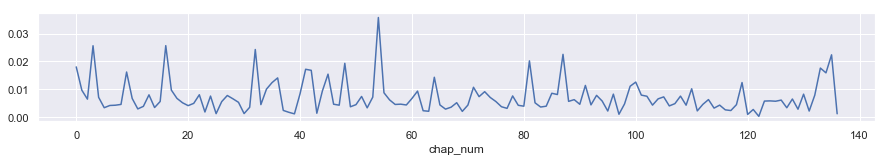

In [42]:
D.tf.plot(figsize=(15,2))

## Get all doc pairs

In [43]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [44]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [45]:
P.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

## Compute Euclidean distance

In [46]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [47]:
P['euclidean'] = 0

In [48]:
P['euclidean'] = P.apply(euclidean, 1)

In [49]:
PME = P.euclidean.unstack().fillna(0)

In [50]:
PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.148935,0.178933,0.134649,0.165440,0.206103,0.216243,0.192921,0.227775,0.181726,0.160496,...,0.205427,0.152789,0.235857,0.141920,0.200777,0.153369,0.122378,0.124066,0.118642,0.306211
1,0.000000,0.191981,0.151821,0.178940,0.215851,0.226502,0.205957,0.237226,0.197075,0.173888,...,0.216288,0.168192,0.246156,0.157179,0.214624,0.169086,0.142820,0.142431,0.138431,0.313163
2,0.000000,0.000000,0.175978,0.199303,0.237575,0.238038,0.224300,0.254091,0.219153,0.198518,...,0.234800,0.196921,0.262186,0.187095,0.234329,0.195780,0.173153,0.173546,0.168802,0.327606
3,0.000000,0.000000,0.000000,0.153469,0.196432,0.218137,0.196114,0.226627,0.182669,0.156499,...,0.205950,0.155997,0.236068,0.143898,0.203655,0.155793,0.126525,0.127738,0.121601,0.306832
4,0.000000,0.000000,0.000000,0.000000,0.221915,0.236660,0.216992,0.246620,0.207385,0.180611,...,0.227940,0.182481,0.255359,0.170599,0.224621,0.181605,0.157943,0.158559,0.153278,0.321734


## Compute Cosine similarity

In [51]:
# normalizes distance between documents unlike eucledian which is just the distance
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [52]:
P['cosine'] = P.apply(cosine, 1)

In [53]:
PMC = P.cosine.unstack().fillna(0)

In [54]:
PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000294,0.000293,0.000286,0.000189,0.000214,0.000372,0.000349,0.000203,0.000479,0.000249,...,0.000269,0.000349,0.000243,0.000267,0.000380,0.000353,0.000322,0.000298,0.000283,0.000224
1,0.000000,0.000343,0.000320,0.000279,0.000422,0.000483,0.000326,0.000342,0.000334,0.000378,...,0.000384,0.000382,0.000269,0.000387,0.000220,0.000358,0.000247,0.000340,0.000281,0.000384
2,0.000000,0.000000,0.000723,0.000735,0.000418,0.001368,0.000726,0.000655,0.000465,0.000518,...,0.000721,0.000231,0.000659,0.000278,0.000457,0.000378,0.000303,0.000340,0.000397,0.000502
3,0.000000,0.000000,0.000000,0.001248,0.001300,0.000413,0.000299,0.000517,0.000628,0.000745,...,0.000450,0.000351,0.000453,0.000366,0.000339,0.000411,0.000314,0.000312,0.000348,0.000351
4,0.000000,0.000000,0.000000,0.000000,0.000889,0.000488,0.000332,0.000375,0.000447,0.000898,...,0.000269,0.000306,0.000284,0.000459,0.000289,0.000428,0.000276,0.000302,0.000365,0.000224


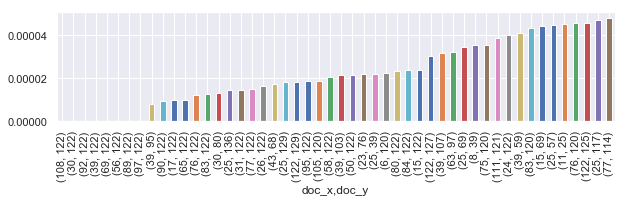

In [55]:
P.cosine.sort_values().head(50).plot(kind='bar', figsize=(10,2 ))

In [56]:
P.cosine.reset_index().to_csv('moby-chapter-pairs.csv', index=False)

## Compare Euclidean and Cosine metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


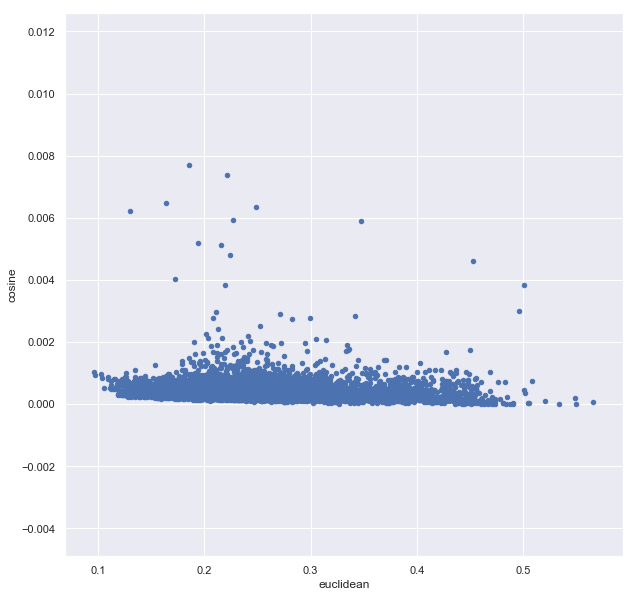

In [57]:
P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10))

In [58]:
P[P.euclidean > .8]

,,euclidean,cosine
doc_x,doc_y,,


## See most similar chapters

In [59]:
P.cosine.sort_values(ascending=False)

doc_x  doc_y
18     22       7.695692e-03
9      83       7.390550e-03
16     18       6.460932e-03
125    129      6.346351e-03
16     22       6.229682e-03
93     129      5.930874e-03
43     78       5.898963e-03
20     22       5.180037e-03
93     125      5.126148e-03
18     20       4.806553e-03
121    122      4.601914e-03
16     20       4.029325e-03
112    113      3.836333e-03
25     97       3.816624e-03
120    122      3.007558e-03
126    127      2.953607e-03
15     17       2.894794e-03
120    129      2.825786e-03
19     21       2.781287e-03
31     121      2.762198e-03
89     90       2.725101e-03
40     129      2.513673e-03
       93       2.412246e-03
110    127      2.242489e-03
40     125      2.178957e-03
126    131      2.117208e-03
107    108      2.109984e-03
62     63       2.084541e-03
126    136      2.048465e-03
127    131      2.029894e-03
                    ...     
6      120      2.232963e-05
25     39       2.180215e-05
23     76       2.170237e-05
5

# Compare Significant Words 

We look at distributions of words over chapters. Note, we are not comparing word vectors per se -- we are looking at sequences of words, which has not been discussed in the literature. 

In [60]:
import matplotlib.pyplot as plt

IndexError: index 0 is out of bounds for axis 0 with size 0

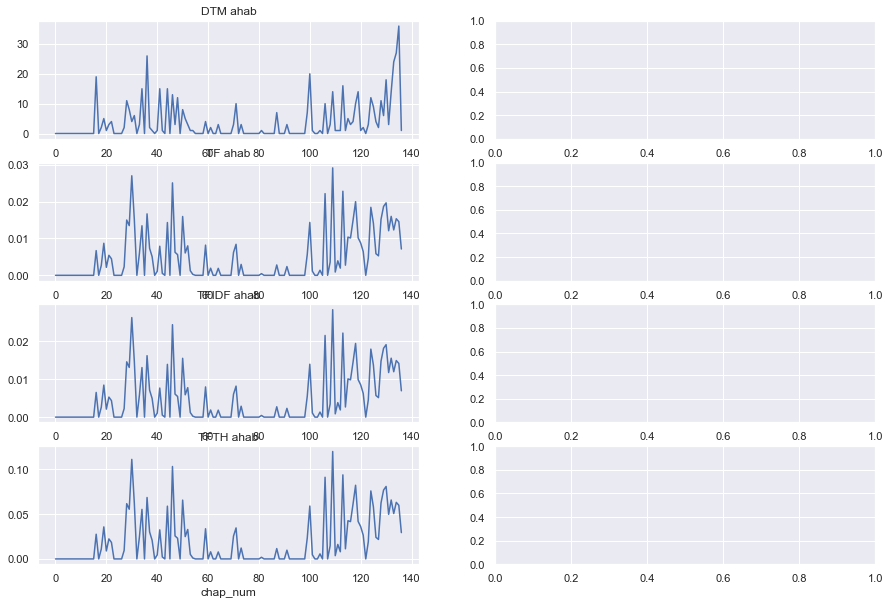

In [63]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('ahab whale'.split()):
    for s in range(0, len(V_list)):
        W = get_term_id(V_list[s], w)
        DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w)) # document term matrix
        TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
        TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
        TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)